# Dealing with missing data

In [1]:
import pandas as pd
from io import StringIO

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
csv = \
"""A,B,C,D
1.0, 2.0, 3.0, 4.0
5.0, 6.0,, 8.0
10.0, 11.0, 12.0,
11.0,,,13.0
,,,
"""

df = pd.read_csv(StringIO(csv))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN
3,11.0,NaN,NaN,13.0
4,NaN,NaN,NaN,NaN


In [3]:
df.isnull().sum(axis=0)

A    1
B    2
C    3
D    2
dtype: int64

In [4]:
df.isnull().sum(axis=1)

0    0
1    1
2    1
3    2
4    4
dtype: int64

In [5]:
df.dropna(axis=0) # rows

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [6]:
df.dropna(axis=1, thresh=3) # columns that have at least 3 not NaN values

,A,B,D
0,1.0,2.0,4.0
1,5.0,6.0,8.0
2,10.0,11.0,NaN
3,11.0,NaN,13.0
4,NaN,NaN,NaN


In [7]:
df.dropna(how='all', axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN
3,11.0,NaN,NaN,13.0


In [8]:
df.dropna(subset=['C']) # drop rows with NaN at column C

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


## Imputing missing values

In [9]:
from sklearn.preprocessing import Imputer

In [11]:
i_mean = Imputer(missing_values='NaN', strategy='mean', axis=0) # aggregate at axis = 0(rows)
i_median = Imputer(strategy='median') # missing_values='NaN' and axis=0 - default values
i_most_freq = Imputer(strategy='most_frequent') # missing_values='NaN' and axis=0 - default values

df_mean = i_mean.fit_transform(df.values)
df_median = i_median.fit_transform(df.values)
df_most_freq = i_most_freq.fit_transform(df.values)

df_mean, df_median, df_most_freq

(array([[  1.        ,   2.        ,   3.        ,   4.        ],
        [  5.        ,   6.        ,   7.5       ,   8.        ],
        [ 10.        ,  11.        ,  12.        ,   8.33333333],
        [ 11.        ,   6.33333333,   7.5       ,  13.        ],
        [  6.75      ,   6.33333333,   7.5       ,   8.33333333]]),
 array([[  1. ,   2. ,   3. ,   4. ],
        [  5. ,   6. ,   7.5,   8. ],
        [ 10. ,  11. ,  12. ,   8. ],
        [ 11. ,   6. ,   7.5,  13. ],
        [  7.5,   6. ,   7.5,   8. ]]),
 array([[  1.,   2.,   3.,   4.],
        [  5.,   6.,   3.,   8.],
        [ 10.,  11.,  12.,   4.],
        [ 11.,   2.,   3.,  13.],
        [  1.,   2.,   3.,   4.]]))

In [12]:
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan],
       [ 11.,  nan,  nan,  13.],
       [ nan,  nan,  nan,  nan]])

In [13]:
i_mean.statistics_, i_median.statistics_, i_most_freq.statistics_

(array([ 6.75      ,  6.33333333,  7.5       ,  8.33333333]),
 array([ 7.5,  6. ,  7.5,  8. ]),
 array([ 1.,  2.,  3.,  4.]))

## Handling categorical data

In [14]:
df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']], columns=['color', 'size', 'price', 'classlabel'])

df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### Mapping ordinal features

In [15]:
size_mapping = {'XL':3, 'L':2, 'M':1}
inv_size_mapping = {v:k for k,v in size_mapping.items()}

df['sizeOrd'] = df['size'].map(size_mapping)

df

,color,size,price,classlabel,sizeOrd
0,green,M,10.1,class1,1
1,red,L,13.5,class2,2
2,blue,XL,15.3,class1,3


In [16]:
df['sizeOrd'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: sizeOrd, dtype: object

### Encoding class labels

In [17]:
class_mapping = {label:ix for ix, label in enumerate(df.classlabel.unique())}
inv_class_mapping = {v:k for k,v in class_mapping.items()}

In [18]:
class_mapping

{'class1': 0, 'class2': 1}

In [19]:
df['classlabelEnc'] = df.classlabel.map(class_mapping)

df

,color,size,price,classlabel,sizeOrd,classlabelEnc
0,green,M,10.1,class1,1,0
1,red,L,13.5,class2,2,1
2,blue,XL,15.3,class1,3,0


In [20]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder().fit(df.classlabel.values)

y = class_le.transform(df.classlabel.values)

y

array([0, 1, 0])

In [21]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### Performing one-hot encoding on nominal features

In [22]:
X = df[['color', 'sizeOrd', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])

X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [23]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])

ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

In [24]:
pd.get_dummies(df[['color', 'sizeOrd', 'price']])

,sizeOrd,price,color_blue,color_green,color_red
0,1,10.1,0.0,1.0,0.0
1,2,13.5,0.0,0.0,1.0
2,3,15.3,1.0,0.0,0.0


## Partitioning a dataset in training and test sets

In [25]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [26]:
df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
              'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanine',
              'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

In [27]:
df['Class label'].unique()

array([1, 2, 3])

In [28]:
df.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanine,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [29]:
from sklearn.cross_validation import train_test_split

X, y = df.iloc[:, 1:], df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

## Bringing features onto the same scale

### MinMaxScaler

In [30]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

mms = MinMaxScaler()

X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

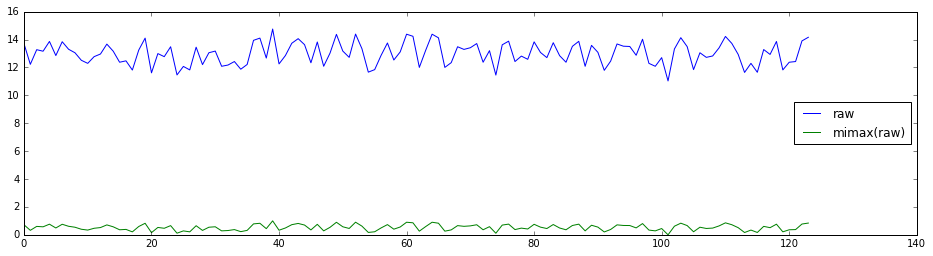

In [40]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 4), sharey=True)
ax1.plot(np.arange(0, X_train.shape[0], 1), X_train.iloc[:, 0], label='raw')
ax1.plot(np.arange(0, X_train_norm.shape[0], 1), X_train_norm[:, 0], label='mimax(raw)')
plt.legend(loc='center right')

### StandardScaler

In [41]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

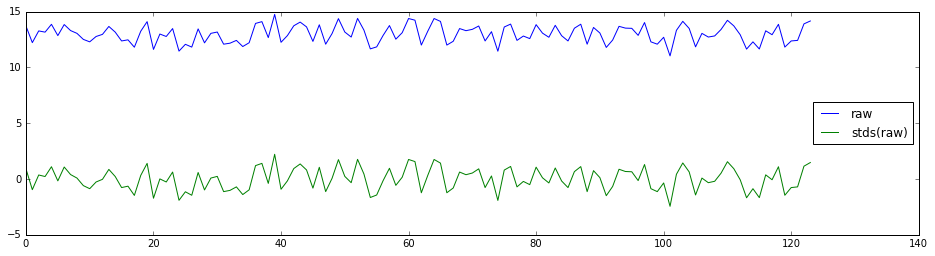

In [45]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 4))
ax1.plot(np.arange(0, X_train.shape[0], 1), X_train.iloc[:, 0], label='raw')
ax1.plot(np.arange(0, X_train_std.shape[0], 1), X_train_std[:, 0], label='stds(raw)')
plt.legend(loc='center right')

## Selecting meaningful features

### Sparse solutions with L1 regularization

In [51]:
from sklearn.linear_model import LogisticRegression

In [56]:
lr = LogisticRegression(penalty='l1', C=.1, random_state=0).fit(X_train_std, y_train)

print('Training accuracy:', lr.score(X_train_std, y_train))

Training accuracy: 0.983870967742


In [57]:
print('Test accuracy', lr.score(X_test_std, y_test))

Test accuracy 0.981481481481


In [58]:
lr.intercept_

array([-0.38378701, -0.15807152, -0.7003578 ])

In [59]:
lr.coef_

array([[ 0.28005053,  0.        ,  0.        , -0.02794534,  0.        ,
         0.        ,  0.71000202,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23648234],
       [-0.6439763 , -0.06875715, -0.05719547,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92671385,
         0.0601997 ,  0.        , -0.3710862 ],
       [ 0.        ,  0.06130014,  0.        ,  0.        ,  0.        ,
         0.        , -0.63706919,  0.        ,  0.        ,  0.4985688 ,
        -0.3580998 , -0.57037067,  0.        ]])

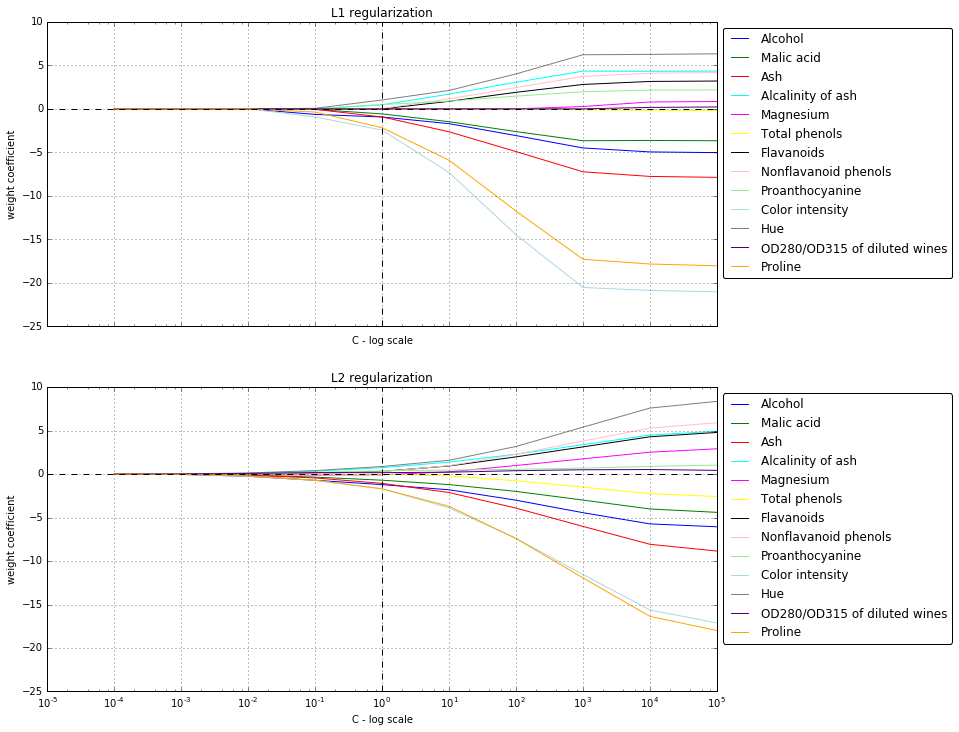

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True, sharey=True)

weights1, weights2, params = [], [], []

colors = ['blue', 'green', 'red', 'cyan', 'magenta',
          'yellow', 'black', 'pink', 'lightgreen',
          'lightblue', 'gray', 'indigo', 'orange']

for c in np.arange(-4, 6):
    
    C = 10**c
    
    lr1 = LogisticRegression(penalty='l1', C=C, random_state=0).fit(X_train_std, y_train)
    weights1.append(lr1.coef_[1])
    
    lr2 = LogisticRegression(penalty='l2', C=C, random_state=0).fit(X_train_std, y_train)
    weights2.append(lr2.coef_[1])
    
    params.append(C)
    
weights1 = np.array(weights1)
weights2 = np.array(weights2)

for column, color in zip(range(weights1.shape[1]), colors):
    
    ax1.plot(params, weights1[:, column], label=df.columns[column+1], color=color)
    ax2.plot(params, weights2[:, column], label=df.columns[column+1], color=color)
    
for ax in [ax1, ax2]:
    
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.axvline(1, color='black', linestyle='--', linewidth=1)
    ax.grid()
    ax.set_xlim([10**(-5), 10**5])
    ax.set_ylabel('weight coefficient')
    ax.set_xlabel('C - log scale')
    ax.set_xscale('log')
    ax.legend(loc='upper center', bbox_to_anchor=(1.18, 1.00), ncol=1, fancybox=True)
    
ax1.set_title('L1 regularization')
ax2.set_title('L2 regularization')

## Sequential feature selection algorithm

In [93]:
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score

class SBS():
    
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=.25, random_state=1):
        
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, 
                                                            random_state=self.random_state)
        
        # inicializa com subset = todas as features
        all_features = tuple(range(X_train.shape[1]))
        self.subsets_ = [all_features]
        
        # score com todas as features
        score = self._calc_score(X_train, y_train, X_test, y_test, self.subsets_[-1])
        self.scores_ = [score]
        
        # enquanto a quantidade de dimensões atual foi maior do que a desejada
        
        for dim in range(X_train.shape[1], self.k_features, -1):
            
            scores = []
            subsets = []
            
            # todas as combinações dim-1 features 
            # importante! notar que a combinação é sobre self.indices_
            # que é inicializado com todas as features, mas é atualizado em cada iteração
            # com as melhores features da iteração
            for p in combinations(self.subsets_[-1], r=dim-1):
                
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                
                scores.append(score)
                subsets.append(p)
                
            # idx da melhor combinação de dim-1 features
            # ou seja, a combinação em que houve menor perda de performance ao se remover uma feature
            best_idx = np.argmax(scores)
            # combinação de features com melhor score
            best_subset = subsets[best_idx]
            self.subsets_.append(best_subset)
            # melhor score da iteração
            best_score = scores[best_idx]
            self.scores_.append(best_score)
            
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        
        return X[:, self.subsets_[-1]]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        
        y_pred = self.estimator.fit(X_train[:, indices], y_train).predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        
        return score

In [94]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1).fit(X_train_std, y_train)

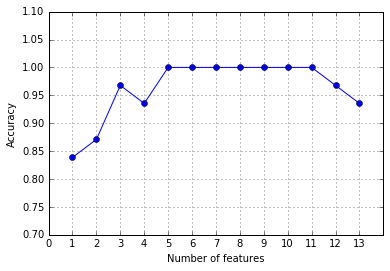

In [96]:
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([.7, 1.1])
plt.xticks(np.arange(0, 14))
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()

In [97]:
k5 = list(sbs.subsets_[8])
print(df.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [98]:
from sklearn.metrics import classification_report

knn.fit(X_train_std, y_train)

print(classification_report(y_train, knn.predict(X_train_std)))

             precision    recall  f1-score   support

          1       0.95      1.00      0.98        40
          2       1.00      0.96      0.98        49
          3       1.00      1.00      1.00        35

avg / total       0.98      0.98      0.98       124



In [99]:
print(classification_report(y_test, knn.predict(X_test_std)))

             precision    recall  f1-score   support

          1       0.86      1.00      0.93        19
          2       1.00      0.86      0.93        22
          3       1.00      1.00      1.00        13

avg / total       0.95      0.94      0.94        54



In [100]:
knn.fit(X_train_std[:, k5], y_train)

print(classification_report(y_train, knn.predict(X_train_std[:, k5])))

             precision    recall  f1-score   support

          1       0.91      1.00      0.95        40
          2       0.98      0.92      0.95        49
          3       1.00      0.97      0.99        35

avg / total       0.96      0.96      0.96       124



In [101]:
print(classification_report(y_test, knn.predict(X_test_std[:, k5])))

             precision    recall  f1-score   support

          1       0.95      1.00      0.97        19
          2       1.00      0.95      0.98        22
          3       0.92      0.92      0.92        13

avg / total       0.96      0.96      0.96        54



## Assessing feature importance with random forests

In [102]:
df.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanine,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [103]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df.columns[1:]

forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1).fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanine                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


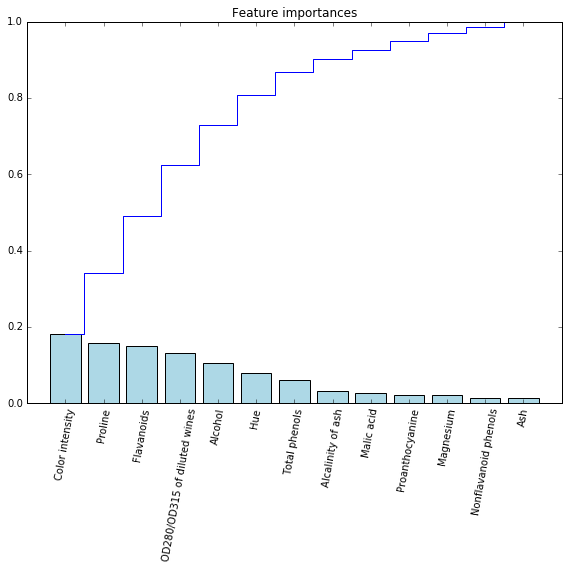

In [104]:
cum_importance = np.cumsum(importances[indices])

_ = plt.figure(figsize=(8, 8))
plt.title('Feature importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')
plt.step(range(X_train.shape[1]), cum_importance, where='mid')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=80)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

In [105]:
forest.feature_importances_

array([ 0.10658906,  0.02539968,  0.01391619,  0.03203319,  0.02207807,
        0.0607176 ,  0.15094795,  0.01464516,  0.02235112,  0.18248262,
        0.07824279,  0.1319868 ,  0.15860977])

### tinha a ideia de plotar as features igualmente espaçadas(theta), com raio proporcional ao valor

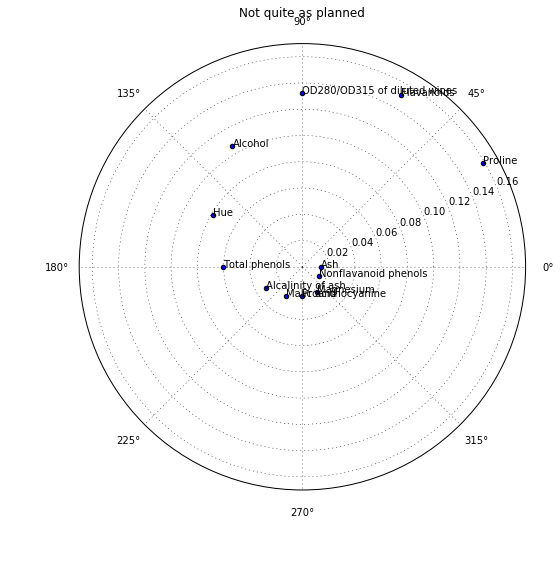

In [113]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
feat_labels = df.columns[1:]

_ = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

theta = np.linspace(0, 2*np.pi, len(importances))

ax.scatter(theta, importances[indices])

for pos, i in enumerate(indices):
    
    ax.annotate(feat_labels[i],
            xy=(theta[pos], importances[i]), 
            xytext=(theta[pos], importances[i])
            )
    
ax.set_title("Not quite as planned")